# Machine Learning Final Project

### Joshua Verhoeff

### 2021-04-12

# Comparing Covolutional Networks and Transfer Learning

## 1. Problem

The goal of this project is test accuracy of a model develpoped using what we have learned in this class, versus a pretrained model

The model I will be constructing on my own is a Multilayer Convolutional Neural Network, using Conv2d, and MaxPooling2d

The pretrained model I will be implementing is the MobileNetV2 model, which is an efficant CNN used for Mobile Vision applications. Documentation can be found [here](https://keras.io/api/applications/mobilenet/)

The achieve this I will be using data challenge on Kaggle called [A Large Scale Fish Database](https://www.kaggle.com/crowww/a-large-scale-fish-dataset)

This is a database that contains roughly 9000 images of 9 types of fish, with the goal of classifying them.

Each picture of a fish comes with a corresponding label as to the species of fish it is, and the goal is to train a model that if given an image of one of these species of fish, the model will be able to identify which species it is.

## 2. Dataset description

```
*** A Large-Scale Dataset for Segmentation and Classification ***

Authors: O. Ulucan, D. Karakaya, M. Turkan
Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey
Corresponding author: M. Turkan
Contact Information: mehmet.turkan@ieu.edu.tr


***General Introduction***

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, 
black sea sprat, striped red mullet, trout, shrimp image samples. 

If you use this dataset in your work, please consider to cite:

@inproceedings{ulucan2020large,
  title={A Large-Scale Dataset for Fish Segmentation and Classification},
  author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
  booktitle={2020 Innovations in Intelligent Systems and Applications Conference (ASYU)},
  pages={1--5},
  year={2020},
  organization={IEEE}
}

* O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)

***Purpose of the work***

This dataset was collected in order to carry out segmentation, feature extraction and classification tasks
and compare the common segmentation, feature extraction and classification algortihms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features).
All of the experiment results prove the usability of our dataset for purposes mentioned above.


***Data Gathering Equipment and Data Augmentation***

Images were collected via 2 different cameras, Kodak Easyshare Z650 and Samsung ST60. 
Therefore, the resolution of the images are 2832 x 2128, 1024 x 768, respectively.

Before the segmentation, feature extraction and classification process, the dataset was resized to 590 x 445
by preserving the aspect ratio. After resizing the images, all labels in the dataset were augmented (by flipping and rotating). 

At the end of the augmentation process, the number of total images for each class became 2000; 1000 for the RGB fish images
and 1000 for their pair-wise ground truth labels. 


***Description of the data in this data set***

The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-waise augmented ground truths.
Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".
 
For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT". 

```

In [1]:
# Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
%matplotlib inline

## 3. Loading the Dataset and Preprocessing

Load in the images and prepare the data for learning

The images are downloaded in a directory structure, with the species name as the folder name

In [2]:
image_dir = Path('input')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepaths))
print(set(labels)) # print all unique labels

{'Sea Bass', 'Sea Bass GT', 'Hourse Mackerel', 'Red Sea Bream', 'Gilt-Head Bream', 'Red Mullet', 'Red Sea Bream GT', 'Shrimp', 'Striped Red Mullet', 'Striped Red Mullet GT', 'Hourse Mackerel GT', 'Trout GT', 'Black Sea Sprat', 'Black Sea Sprat GT', 'Red Mullet GT', 'Trout', 'Gilt-Head Bream GT', 'Shrimp GT'}


In [3]:
# Convert into Pandas Dataframe
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_data = pd.concat([filepaths, labels], axis=1)

# Drop the GT (Ground Truth) Images
image_data = image_data[image_data['Label'].apply(lambda x : x[-2:] != 'GT')]
image_data.head()

Filepath            Label
0  input\Black Sea Sprat\Black Sea Sprat\00001.png  Black Sea Sprat
1  input\Black Sea Sprat\Black Sea Sprat\00002.png  Black Sea Sprat
2  input\Black Sea Sprat\Black Sea Sprat\00003.png  Black Sea Sprat
3  input\Black Sea Sprat\Black Sea Sprat\00004.png  Black Sea Sprat
4  input\Black Sea Sprat\Black Sea Sprat\00005.png  Black Sea Sprat

In [4]:
# Shuffle the data and reset the index
image_data = image_data.sample(frac=1).reset_index(drop=True)

image_data.head()

Filepath            Label
0  input\Hourse Mackerel\Hourse Mackerel\00148.png  Hourse Mackerel
1                input\Sea Bass\Sea Bass\00376.png         Sea Bass
2            input\Red Mullet\Red Mullet\00298.png       Red Mullet
3      input\Red Sea Bream\Red Sea Bream\00751.png    Red Sea Bream
4                    input\Shrimp\Shrimp\00390.png           Shrimp

In [5]:
image_data.shape

(9000, 2)

<Figure size 720x720 with 0 Axes>

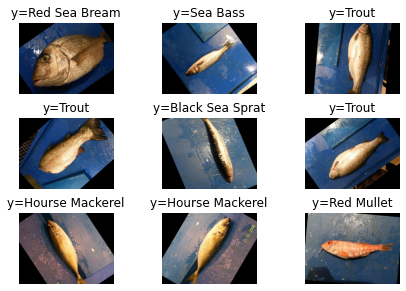

In [6]:
# Display random images
def show_images(k, x, y=None):
    plt.figure(figsize=(10, 10))
    plt.subplots(k, k)
    plt.tight_layout(pad=0.3)
    for i in range(k*k):
        r = np.random.randint(0, len(x)-1)
        plt.subplot(k, k, i+1)
        plt.imshow(plt.imread(x[r]))
        plt.axis('off')
        if y is not None:
            plt.title('y=%s' % y[r])
show_images(3, image_data['Filepath'], image_data['Label'])

## 4. Load Images with a generator

Due to the size of the dataset, need to load the data using generators

Data is first split into training and testing using a 70%-30% ratio, with 20% of the training data being used for validation

In [8]:
# First split the data using function from sklearn
train_data, test_data = train_test_split(image_data, train_size=0.7, shuffle=True, random_state=1)

In [9]:
# import tesorflow and keras libraries
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets as datasets
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.preprocessing as preprocessing

In [10]:
# Training genrator
train_generator = preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v2.preprocess_input,
    validation_split = 0.2
)

# Testing generator
test_generator = preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = train_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5040 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.


## 5. Create Convolutional Network

Using the methods discussed in class construct a multilayer Convolutional Network  To classify the fish dataset

In [15]:
convolutional_model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu', name='conv2d_1'),
    layers.MaxPooling2D((2,2), name='max_pooling_1'),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', name='conv2d_2'),
    layers.MaxPooling2D((2,2), name='max_pooling_2'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv2d_3'),
    layers.MaxPooling2D((2,2), name='max_pooling_3'),
    layers.Flatten(name='flatten'),
    layers.Dense(1024, activation='relu', name='dense_1'),
    layers.Dense(9, activation='softmax', name='output')
], name='convolutional_network')

convolutional_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.categorical_crossentropy,
    metrics=['acc'],
)

convolutional_model.summary()

Model: "convolutional_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling_1 (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling_2 (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling_3 (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)   

In [16]:
# Train the model
convolutional_history = convolutional_model.fit(
    train_images, 
    validation_data=validation_images,
    epochs=5,
    verbose=1
)

Train for 158 steps, validate for 40 steps
Epoch 1/5
158/158 [==============================] - 114s 724ms/step - loss: 1.3515 - acc: 0.6014 - val_loss: 0.3398 - val_acc: 0.8857
Epoch 2/5
158/158 [==============================] - 113s 718ms/step - loss: 0.1784 - acc: 0.9415 - val_loss: 0.1935 - val_acc: 0.9278
Epoch 3/5
158/158 [==============================] - 114s 724ms/step - loss: 0.0578 - acc: 0.9827 - val_loss: 0.0895 - val_acc: 0.9770
Epoch 4/5
158/158 [==============================] - 114s 723ms/step - loss: 0.0210 - acc: 0.9944 - val_loss: 0.0675 - val_acc: 0.9770
Epoch 5/5
158/158 [==============================] - 116s 734ms/step - loss: 0.0123 - acc: 0.9976 - val_loss: 0.0885 - val_acc: 0.9730


<Figure size 1080x1080 with 0 Axes>

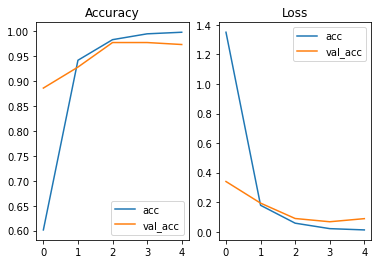

In [17]:
# Graph accuracy and loss
xx = convolutional_history.epoch

plt.figure(figsize=(15,15))
plt.subplots(2,1)

plt.subplot(1,2,1)
plt.plot(xx, convolutional_history.history['acc'], label='acc')
plt.plot(xx, convolutional_history.history['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(xx, convolutional_history.history['loss'], label='acc')
plt.plot(xx, convolutional_history.history['val_loss'], label='val_acc')
plt.title('Loss')
plt.legend()
plt.show()

## 4. Create and Train Transfer Learning Model

Use the Mobile Net V2 model from Google to classify the images

In [18]:
# Load the model
pretrained_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [66]:
# Add input and output layers to the model
inputs = pretrained_model.input
x = layers.Dense(128, activation='relu')(pretrained_model.output)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(9, activation='softmax')(x)
transfer_learning_model = keras.Model(inputs=inputs, outputs=outputs)

transfer_learning_model.compile(
    optimizer= optimizers.Adam(),
    loss= losses.categorical_crossentropy,
    metrics=['acc']
)

In [67]:
transfer_learning_history = transfer_learning_model.fit(
    train_images,
    validation_data=validation_images,
    epochs=5,
    verbose=1
)

Train for 158 steps, validate for 40 steps
Epoch 1/5
158/158 [==============================] - 340s 2s/step - loss: 0.3767 - acc: 0.8782 - val_loss: 0.4807 - val_acc: 0.8452
Epoch 2/5
158/158 [==============================] - 340s 2s/step - loss: 0.0666 - acc: 0.9786 - val_loss: 0.5457 - val_acc: 0.8167
Epoch 3/5
158/158 [==============================] - 332s 2s/step - loss: 0.0250 - acc: 0.9929 - val_loss: 0.4792 - val_acc: 0.8476
Epoch 4/5
158/158 [==============================] - 336s 2s/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.9353 - val_acc: 0.7595
Epoch 5/5
158/158 [==============================] - 336s 2s/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.7524 - val_acc: 0.8016


<Figure size 1080x1080 with 0 Axes>

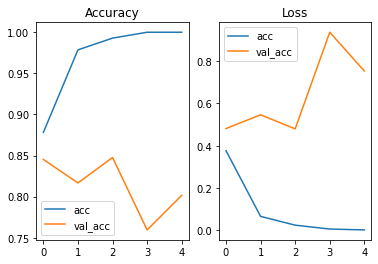

In [68]:
# Graph the Accuracy and the loss
xx = transfer_learning_history.epoch

plt.figure(figsize=(15,15))
plt.subplots(2,1)

plt.subplot(1,2,1)
plt.plot(xx, transfer_learning_history.history['acc'], label='acc')
plt.plot(xx, transfer_learning_history.history['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(xx, transfer_learning_history.history['loss'], label='acc')
plt.plot(xx, transfer_learning_history.history['val_loss'], label='val_acc')
plt.title('Loss')
plt.legend()
plt.show()

## 5. Test the Models

In [69]:
# convolutional model
convolutional_results = convolutional_model.evaluate(test_images, verbose=1)

85/85 [==============================] - 29s 336ms/step - loss: 0.1083 - acc: 0.9656


In [70]:
print("Convolutional Test Loss:     {:.4f}".format(convolutional_results[0]))
print("Convolutional Test Accuracy: {:.2f}%".format(convolutional_results[1]*100))

Convolutional Test Loss:     0.1083
Convolutional Test Accuracy: 96.56%


In [71]:
# Transfer Learning Model
transfer_learning_results = transfer_learning_model.evaluate(test_images, verbose=1)
print("Transfer Learning Test Loss:     {:.4f}".format(transfer_learning_results[0]))
print("Transfer Learning Test Accuracy: {:.2f}%".format(transfer_learning_results[1]*100))

85/85 [==============================] - 50s 586ms/step - loss: 0.9166 - acc: 0.8019
Transfer Learning Test Loss:     0.9166
Transfer Learning Test Accuracy: 80.19%


Predict the labels for the test images using the 2 models

In [72]:
# Make a prediction using convolutional model
convolutional_pred = convolutional_model.predict(test_images)
convolutional_pred = np.argmax(convolutional_pred, axis=1)

# map the labels
labels = (train_images.class_indices)
labels = dict((x,y) for y,x in labels.items())
convolutional_pred = [labels[k] for k in convolutional_pred]

# display labels
print(f'The first 10 predictions are:\n{convolutional_pred[:10]}')

The first 10 predictions are:
['Sea Bass', 'Red Sea Bream', 'Red Sea Bream', 'Gilt-Head Bream', 'Striped Red Mullet', 'Striped Red Mullet', 'Black Sea Sprat', 'Red Sea Bream', 'Red Mullet', 'Black Sea Sprat']


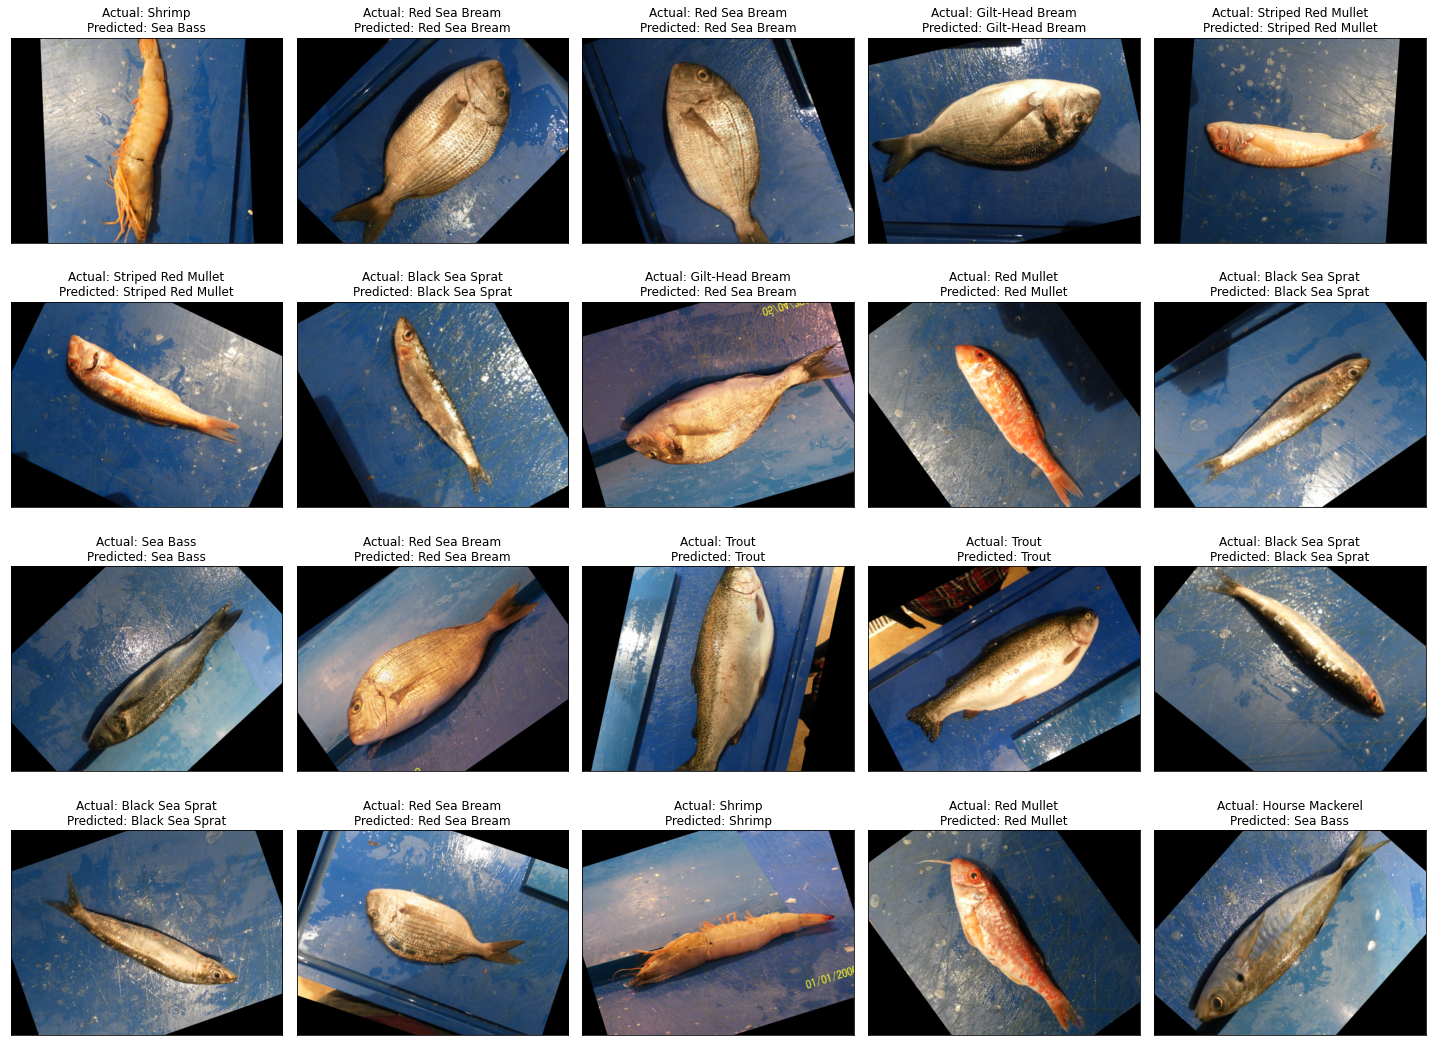

In [73]:
# display 20 images with the labels
fig, axes = plt.subplots(4, 5, figsize=(20,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_data['Filepath'].iloc[i]))
    ax.set_title(f"Actual: {test_data['Label'].iloc[i]}\nPredicted: {convolutional_pred[i]}")
plt.tight_layout()
plt.show()

In [74]:
# Make a prediction using transfer learning model
transfer_learning_pred = transfer_learning_model.predict(test_images)
transfer_learning_pred = np.argmax(transfer_learning_pred, axis=1)

# map the labels
transfer_learning_pred = [labels[k] for k in transfer_learning_pred]

# display labels
print(f'The first 10 predictions are:\n{transfer_learning_pred[:10]}')

The first 10 predictions are:
['Striped Red Mullet', 'Red Sea Bream', 'Red Sea Bream', 'Red Sea Bream', 'Striped Red Mullet', 'Striped Red Mullet', 'Black Sea Sprat', 'Gilt-Head Bream', 'Red Mullet', 'Black Sea Sprat']


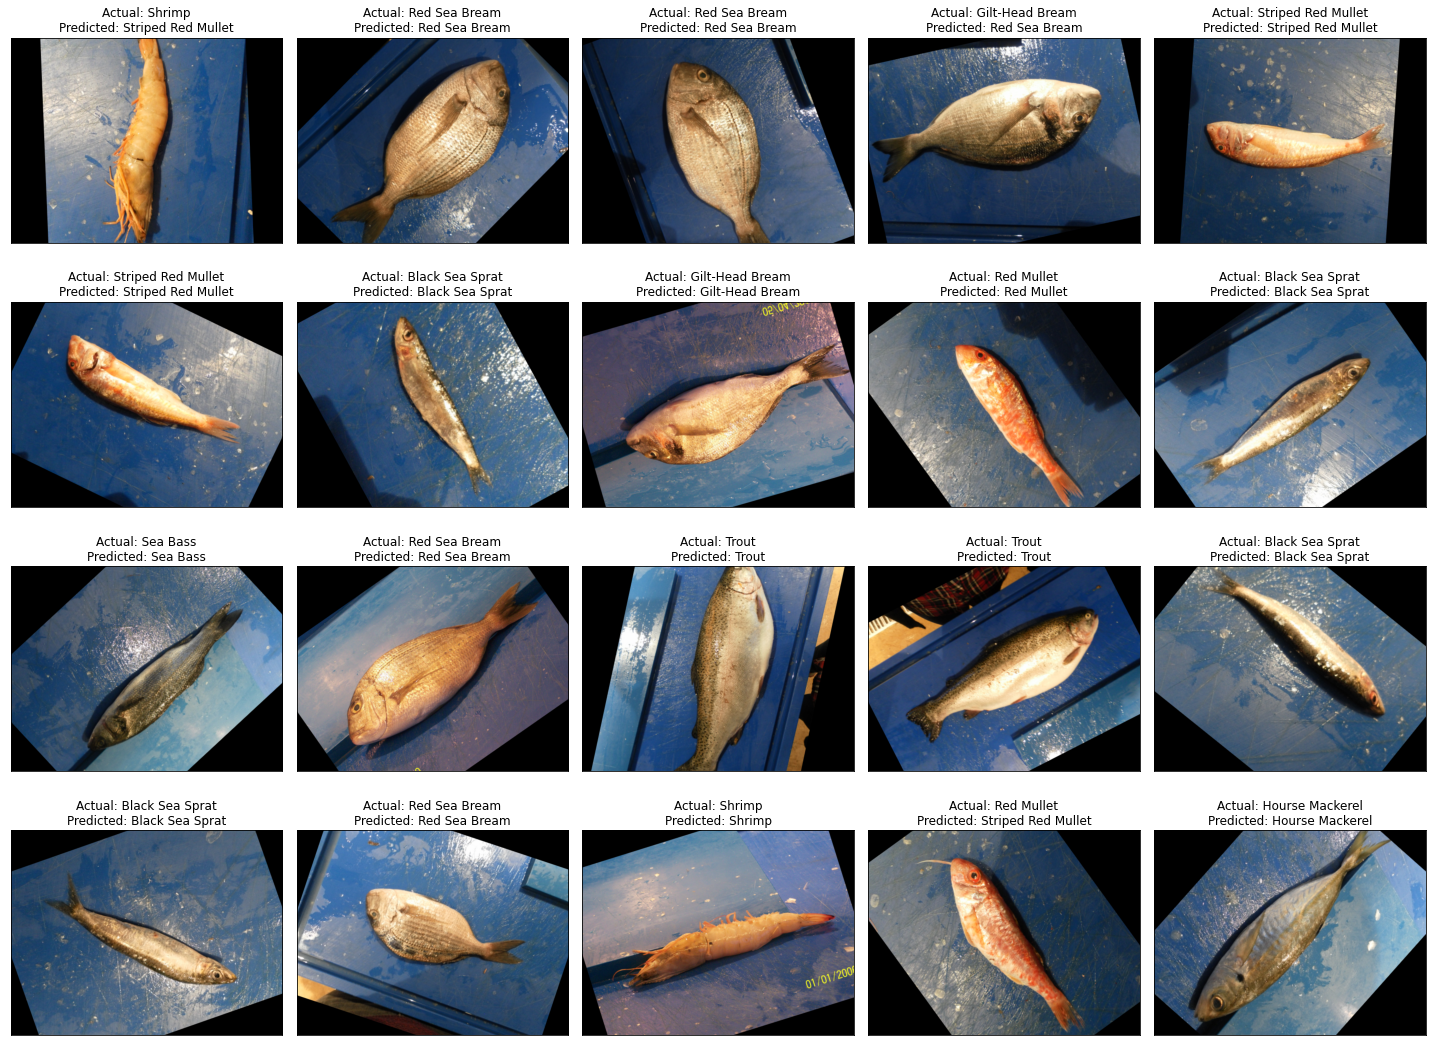

In [75]:
# display 20 images with the labels
fig, axes = plt.subplots(4, 5, figsize=(20,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_data['Filepath'].iloc[i]))
    ax.set_title(f"Actual: {test_data['Label'].iloc[i]}\nPredicted: {transfer_learning_pred[i]}")
plt.tight_layout()
plt.show()

## 6. Analyze Results

After testing the models it shows that the Multilayer CNN that I created gave more accurate results than the 
transfer learning model

The Convolutional model had a testing accuracy of 96.56%, while the transfer learning model had a testing accuracy of 80.19%

This can be because of a number of reasons, first and formost the size of the transfer leaning model. When training the transfer learning model, I observed that the accuracy was near 100%, but the validation accuracy was around 80%. This means that the model could have been overfitted, and this lead to model not beiong able to predict the fish species as accuratly in testing. 

Another possibility of why the transfer learning model was less accurate is that the dataset was too large for my computer to handle for processing this model. This could have caused the model to be calculated inaccuratly and skewed the results.